In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import brentq
from scipy.stats import norm
from scipy.optimize import minimize, basinhopping
from scipy.stats import qmc
import warnings
from scipy.integrate import quad, IntegrationWarning
from joblib import Parallel, delayed
from numba import njit, prange
import math

## Vanilla option pricing experiments

In [2]:
#Initial parameter values for Monte Carlo simulation
initial_spot_price = 100.0    
mu  = 0.03      
sigma  = 0.18       
num_paths = 500000   
time_steps = 500        
T  = 1.0        

# Initial parameter values for Heston model
r     = 0.03               
kappa = 3.0               
theta = 0.030               
rho   = -0.50               
v0    = 0.028             
sigma_bs = 0.18             
dt = 1 / time_steps

strike_grid   = np.linspace(100, 120, 15)
maturity_grid = np.linspace(1.0, 2.0, 11)

### Price European Calls - Monte Carlo Engine and Semi-Closed Heston Formula


In [3]:
import numpy as np
import pandas as pd


def price_heston_mc(
    initial_spot_price,
    v0,
    r,
    kappa,
    theta,
    sigma_volvol,
    rho,
    strike_grid,
    maturity_grid,
    n_paths=num_paths,
    dt=time_steps,
):
    """
    Monte Carlo pricing of European call options under the Heston model
    using the full truncation Euler scheme.

    Returns:
        np.ndarray: prices array of shape
            (len(strike_grid), len(maturity_grid)).
    """
    num_strikes = len(strike_grid)
    num_maturities = len(maturity_grid)
    prices = np.zeros((num_strikes, num_maturities))

    for j, maturity in enumerate(maturity_grid):
        steps = int(np.ceil(maturity / dt))
        dt_per_step = maturity / steps

        spot = np.full(n_paths, initial_spot_price, dtype=float)
        variance = np.full(n_paths, v0, dtype=float)

        for _ in range(steps):
            z1 = np.random.randn(n_paths)
            z2 = np.random.randn(n_paths)
            z_var = z1
            z_spot = rho * z1 + np.sqrt(1 - rho**2) * z2

            var_pos = np.maximum(variance, 0.0)
            variance += (
                kappa * (theta - var_pos) * dt_per_step
                + sigma_volvol * np.sqrt(var_pos * dt_per_step) * z_var
            )
            variance = np.maximum(variance, 0.0)

            spot *= np.exp(
                (r - 0.5 * var_pos) * dt_per_step
                + np.sqrt(var_pos * dt_per_step) * z_spot
            )

        discount_factor = np.exp(-r * maturity)
        for i, K in enumerate(strike_grid):
            payoff = np.maximum(spot - K, 0.0)
            prices[i, j] = discount_factor * np.mean(payoff)

    return prices


# Compute prices and display results
prices_monte_carlo = price_heston_mc(
    initial_spot_price,
    v0,
    r,
    kappa,
    theta,
    sigma_bs,
    rho,
    strike_grid,
    maturity_grid,
    n_paths=num_paths,
    dt=dt,
)

df_monte_carlo = pd.DataFrame(
    prices_monte_carlo,
    index=[f"K={k:.2f}" for k in strike_grid],
    columns=[f"T={m:.2f}" for m in maturity_grid],
)

print(df_monte_carlo.to_string())

            T=1.00    T=1.10    T=1.20    T=1.30     T=1.40     T=1.50     T=1.60     T=1.70     T=1.80     T=1.90     T=2.00
K=100.00  8.274957  8.784939  9.241339  9.701708  10.157419  10.568414  10.981393  11.405079  11.784887  12.178023  12.615806
K=101.43  7.522890  8.030536  8.486042  8.947140   9.402745   9.814462  10.226958  10.651992  11.032870  11.426787  11.863872
K=102.86  6.816711  7.319304  7.772348  8.232388   8.686066   9.096606   9.507535   9.932346  10.313678  10.706844  11.143017
K=104.29  6.156130  6.651449  7.099764  7.556824   8.006885   8.414560   8.823149   9.246272   9.626897  10.018044  10.452838
K=105.71  5.540871  6.026324  6.467783  6.920362   7.365260   7.768257   8.173414   8.593104   8.972578   9.360408   9.793089
K=107.14  4.970016  5.443218  5.875797  6.322474   6.760418   7.157518   7.558264   7.973046   8.350619   8.734044   9.163350
K=108.57  4.442252  4.901497  5.323257  5.762357   6.191592   6.582040   6.976720   7.385853   7.760659   8.138457   8

### Heston

In [4]:
def robust_quad(
    f,
    a=0.0,
    b=np.inf,
    epsabs=1e-6,
    epsrel=1e-6,
    limit=200,
):
    """
    Robust integration handling infinite upper limits by splitting.

    Parameters:
        f (callable): integrand function of one variable.
        a (float): lower integration limit.
        b (float): upper integration limit (can be np.inf).
        epsabs (float): absolute error tolerance.
        epsrel (float): relative error tolerance.
        limit (int): max subdivisions.

    Returns:
        float: integral of f from a to b.
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=IntegrationWarning)
        if np.isinf(b):
            u_max = 200.0  # finite cutoff for infinite tail
            integral1, _ = quad(f, a, u_max, epsabs=epsabs,
                                epsrel=epsrel, limit=limit)
            integral2, _ = quad(f, u_max, b, epsabs=epsabs,
                                epsrel=epsrel, limit=limit)
            return integral1 + integral2
        return quad(f, a, b, epsabs=epsabs,
                    epsrel=epsrel, limit=limit)[0]


def heston_cf(
    phi,
    initial_spot_price,
    T,
    r,
    kappa,
    theta,
    sigma_v,
    rho,
    v0,
) -> complex:
    """
    Characteristic function for the log-asset under Heston.

    Parameters follow Heston model notation.

    Returns:
        complex: value of characteristic function at phi.
    """
    a = kappa * theta
    b_param = kappa - rho * sigma_v * 1j * phi
    d = np.sqrt(b_param * b_param +
                sigma_v**2 * (1j * phi + phi**2))
    g = (b_param - d) / (b_param + d)
    exp_term = np.exp(1j * phi *
                      (np.log(initial_spot_price) + r * T))
    C = (
        r * 1j * phi * T
        + a / sigma_v**2 * ((b_param - d) * T
        - 2 * np.log((1 - g * np.exp(-d * T)) / (1 - g)))
    )
    D = ((b_param - d) / sigma_v**2
         * (1 - np.exp(-d * T)) / (1 - g * np.exp(-d * T)))
    return exp_term * np.exp(C + D * v0)


def heston_call_price(
    initial_spot_price,
    strike,
    maturity,
    r,
    kappa,
    theta,
    sigma,
    rho,
    v0,
) -> float:
    """
    Price a European call under Heston semi-analytically.

    strike: strike price (K)
    maturity: time to maturity (T)
    sigma: vol-of-vol parameter
    Other params as in Heston model.
    """
    def integrand_p1(u):
        cf_val = heston_cf(u - 1j,
                          initial_spot_price,
                          maturity,
                          r,
                          kappa,
                          theta,
                          sigma,
                          rho,
                          v0)
        return np.real(
            np.exp(-1j * u * np.log(strike))
            * cf_val
            / (1j * u * initial_spot_price * np.exp(r * maturity))
        )

    def integrand_p2(u):
        cf_val = heston_cf(u,
                          initial_spot_price,
                          maturity,
                          r,
                          kappa,
                          theta,
                          sigma,
                          rho,
                          v0)
        return np.real(
            np.exp(-1j * u * np.log(strike))
            * cf_val
            / (1j * u)
        )

    P1 = 0.5 + 1 / np.pi * robust_quad(integrand_p1, 0.0, np.inf)
    P2 = 0.5 + 1 / np.pi * robust_quad(integrand_p2, 0.0, np.inf)
    return initial_spot_price * P1 - strike * np.exp(-r * maturity) * P2


# Compute analytic prices and display results
prices_analytic = np.zeros((len(strike_grid), len(maturity_grid)))

for i, strike in enumerate(strike_grid):
    for j, maturity in enumerate(maturity_grid):
        prices_analytic[i, j] = heston_call_price(
            initial_spot_price,
            strike,
            maturity,
            r,
            kappa,
            theta,
            sigma_bs,
            rho,
            v0,
        )


df_analytical = pd.DataFrame(
    prices_analytic,
    index=[f"K={strike:.2f}" for strike in strike_grid],
    columns=[f"T={maturity:.2f}" for maturity in maturity_grid],
)

print(df_analytical.to_string())


            T=1.00    T=1.10    T=1.20     T=1.30     T=1.40     T=1.50     T=1.60     T=1.70     T=1.80     T=1.90     T=2.00
K=100.00  8.767664  9.321761  9.862980  10.392987  10.913136  11.424548  11.928160  12.424767  12.915047  13.399587  13.878896
K=101.43  7.920360  8.469966  9.007221   9.533702  10.050695  10.559267  11.060314  11.554596  12.042766  12.525387  13.002949
K=102.86  7.116505  7.659179  8.190344   8.711424   9.223592   9.727826  10.224954  10.715680  11.200612  11.680276  12.155133
K=104.29  6.356654  6.889920  7.412835   7.926609   8.432255   8.930629   9.422461   9.908377  10.388924  10.864577  11.335754
K=105.71  5.641080  6.162469  6.674972   7.179531   7.676953   8.167936   8.653085   9.132931   9.607938  10.078517  10.545032
K=107.14  4.969767  5.476860  5.976826   6.470283   6.957794   7.439865   7.916953   8.389470   8.857784   9.322227   9.783099
K=108.57  4.342415  4.832885  5.318255   5.798775   6.274723   6.746391   7.214063   7.678011   8.138492   8.59

### Plot analytic vs mc

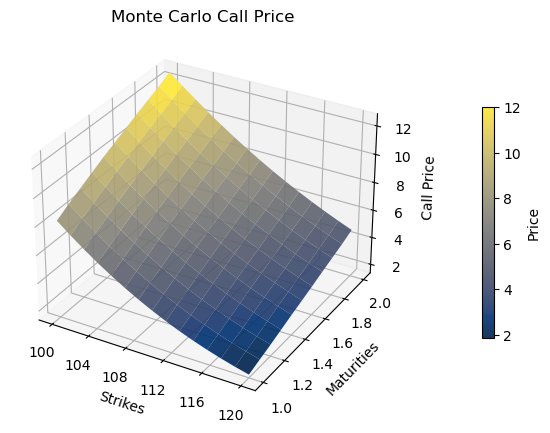

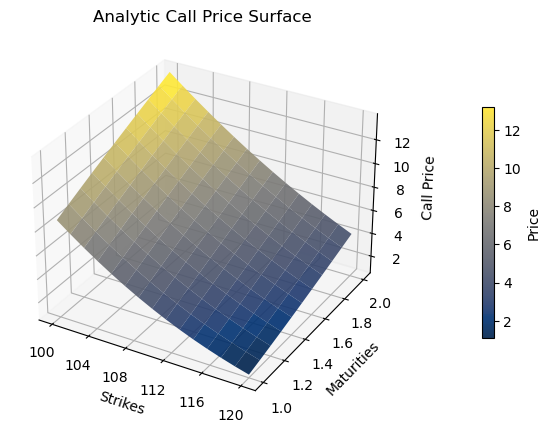

In [5]:
T_mesh, K_mesh = np.meshgrid(maturity_grid, strike_grid)

# plot Monte Carlo - Euler Maruyama
# Create mesh grids for strikes and maturities
T_mesh, K_mesh = np.meshgrid(maturity_grid, strike_grid)

# Monte Carlo - Euler-Maruyama price surface
fig_mc = plt.figure(figsize=(7.5, 5))
ax_mc = fig_mc.add_subplot(111, projection='3d')
surface_mc = ax_mc.plot_surface(
    K_mesh,
    T_mesh,
    prices_monte_carlo,
    cmap='cividis',
    alpha=0.9
)
ax_mc.set_xlabel('Strikes')
ax_mc.set_ylabel('Maturities')
ax_mc.set_zlabel('Call Price')
ax_mc.set_title('Monte Carlo Call Price')
ax_mc.set_xticks(np.linspace(100, 120, 6))
ax_mc.set_yticks(np.linspace(1.0, 2.0, 6))
cbar_mc = fig_mc.colorbar(
    surface_mc,
    ax=ax_mc,
    pad=0.15,
    shrink=0.6
)
cbar_mc.set_label('Price')
fig_mc.savefig(
    'monte_carlo_call_price.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

# Analytic - Semi-closed Heston formula price surface
fig_analytic = plt.figure(figsize=(7.5, 5))
ax_analytic = fig_analytic.add_subplot(111, projection='3d')
surface_analytic = ax_analytic.plot_surface(
    K_mesh,
    T_mesh,
    prices_analytic,
    cmap='cividis',
    alpha=0.9
)
ax_analytic.set_xlabel('Strikes')
ax_analytic.set_ylabel('Maturities')
ax_analytic.set_zlabel('Call Price')
ax_analytic.set_title('Analytic Call Price Surface')
ax_analytic.set_xticks(np.linspace(100, 120, 6))
ax_analytic.set_yticks(np.linspace(1.0, 2.0, 6))
cbar_analytic = fig_analytic.colorbar(
    surface_analytic,
    ax=ax_analytic,
    pad=0.15,
    shrink=0.6
)
cbar_analytic.set_label('Price')
fig_analytic.savefig(
    'heston_call_price.png',
    dpi=300,
    bbox_inches='tight'
)
plt.show()


### IV

In [6]:
# Functional Component: pricing and implied-volatility

def BS_call_price(
    initial_spot_price,
    strike,
    maturity,
    r,
    sigma,
) -> float:
    """
    Black–Scholes European call option price.

    Parameters:
        initial_spot_price (float): current asset price S0.
        strike (float): strike price K.
        maturity (float): time to maturity T.
        r (float): risk-free interest rate.
        sigma (float): volatility parameter.

    Returns:
        float: call option price.
    """
    m = strike / initial_spot_price
    sqrt_T = np.sqrt(maturity)
    d1 = (-np.log(m)
          + (r + 0.5 * sigma ** 2) * maturity)
    d1 /= sigma * sqrt_T
    d2 = (-np.log(m)
          + (r - 0.5 * sigma ** 2) * maturity)
    d2 /= sigma * sqrt_T
    return (initial_spot_price * norm.cdf(d1)
            - strike * np.exp(-r * maturity) * norm.cdf(d2))


def implied_vol_brentq(
    C_target,
    initial_spot_price,
    strike,
    maturity,
    r,
    low=1e-6,
    high=5.0,
    tol=1e-8,
    maxiter=1000,
) -> float:
    """
    Find implied volatility via Brent’s method.

    Returns np.nan if C_target is outside feasible bounds.
    """
    intrinsic = max(
        initial_spot_price - strike * np.exp(-r * maturity), 0.0
    )
    if C_target < intrinsic or C_target > initial_spot_price:
        return np.nan

    def objective(sigma: float) -> float:
        """Objective function for root finding: BS_price - C_target."""
        return (
            BS_call_price(
                initial_spot_price,
                strike,
                maturity,
                r,
                sigma,
            ) - C_target
        )

    try:
        return brentq(
            objective,
            low,
            high,
            xtol=tol,
            rtol=tol,
            maxiter=maxiter,
        )
    except ValueError:
        return np.nan



def implied_vol_surface(
    prices,
    strike_grid,
    maturity_grid,
    initial_spot_price,
    r,
    low=1e-6,
    high=5.0,
    tol=1e-8,
    maxiter=100,
):
    """
    Compute implied-volatility surface for a grid of call prices.

    Returns an array and a DataFrame labeled by strikes and maturities.
    """
    n_strikes = len(strike_grid)
    n_maturities = len(maturity_grid)
    iv_array = np.zeros((n_strikes, n_maturities))

    for i, K in enumerate(strike_grid):
        for j, T in enumerate(maturity_grid):
            iv_array[i, j] = implied_vol_brentq(
                prices[i, j],
                initial_spot_price,
                K,
                T,
                r,
                low=low,
                high=high,
                tol=tol,
                maxiter=maxiter,
            )

    iv_df = pd.DataFrame(
        iv_array,
        index=[f"K={k:.2f}" for k in strike_grid],
        columns=[f"T={t:.2f}" for t in maturity_grid],
    )
    return iv_array, iv_df


# Compute implied-volatility surfaces
iv_mc_array, iv_mc_df = implied_vol_surface(
    prices_monte_carlo,
    strike_grid,
    maturity_grid,
    initial_spot_price,
    r,
)
iv_an_array, iv_an_df = implied_vol_surface(
    prices_analytic,
    strike_grid,
    maturity_grid,
    initial_spot_price,
    r,
)
print(iv_mc_df.to_string(), "\n")
print(iv_an_df.to_string())

            T=1.00    T=1.10    T=1.20    T=1.30    T=1.40    T=1.50    T=1.60    T=1.70    T=1.80    T=1.90    T=2.00
K=100.00  0.170521  0.171352  0.171206  0.171471  0.171883  0.171540  0.171464  0.171793  0.171396  0.171424  0.172431
K=101.43  0.169711  0.170538  0.170430  0.170754  0.171194  0.170904  0.170845  0.171215  0.170864  0.170920  0.171904
K=102.86  0.168924  0.169743  0.169682  0.170064  0.170528  0.170278  0.170240  0.170644  0.170345  0.170417  0.171396
K=104.29  0.168157  0.168973  0.168952  0.169389  0.169875  0.169658  0.169651  0.170084  0.169833  0.169917  0.170902
K=105.71  0.167412  0.168221  0.168233  0.168732  0.169243  0.169048  0.169073  0.169526  0.169332  0.169421  0.170419
K=107.14  0.166684  0.167482  0.167524  0.168092  0.168622  0.168450  0.168513  0.168979  0.168846  0.168939  0.169946
K=108.57  0.165966  0.166762  0.166829  0.167465  0.168009  0.167870  0.167961  0.168448  0.168377  0.168467  0.169488
K=110.00  0.165264  0.166068  0.166157  0.166851

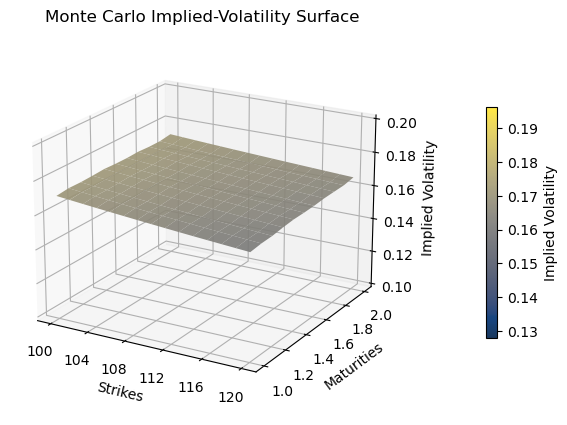

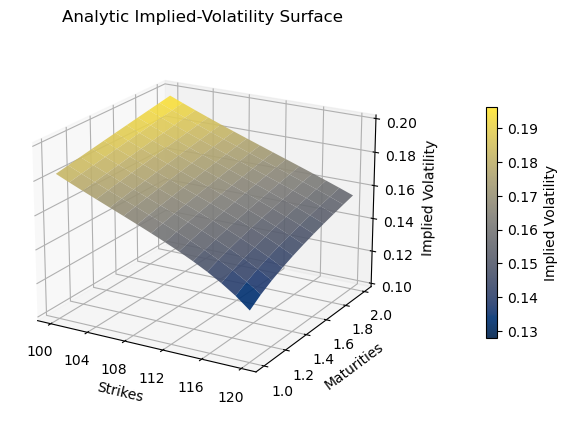

In [7]:
# Create meshgrid for strikes (X) and maturities (Y)
T_mesh, K_mesh = np.meshgrid(
    maturity_grid, strike_grid,
)
# Determine color scale limits
vmin = np.nanmin([iv_mc_array, iv_an_array])
vmax = np.nanmax([iv_mc_array, iv_an_array])

# Helper to plot a surface

def plot_surface(
    X,
    Y,
    Z,
    title,
    filename,
):
    """
    Plot and save a 3D surface for implied volatility.
    """
    fig = plt.figure(figsize=(7.8, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(
        X,
        Y,
        Z,
        cmap='cividis',
        alpha=0.9,
        edgecolor='none',
        vmin=vmin,
        vmax=vmax,
    )
    ax.view_init(elev=20)
    ax.set_xlabel('Strikes')
    ax.set_ylabel('Maturities')
    ax.set_zlabel('Implied Volatility')
    ax.set_zlim(0.1, 0.2)
    ax.set_title(title)
    ax.set_xticks(np.linspace(100, 120, 6))
    ax.set_yticks(np.linspace(1.0, 2.0, 6))
    cbar = fig.colorbar(
        surf,
        ax=ax,
        pad=0.15,
        shrink=0.6,
    )
    cbar.set_label('Implied Volatility')
    fig.savefig(
        f"{filename}.png",
        dpi=300,
        bbox_inches='tight',
    )
    plt.show()


# Plot Monte Carlo and Analytic surfaces
plot_surface(
    K_mesh,
    T_mesh,
    iv_mc_array,
    'Monte Carlo Implied-Volatility Surface',
    'monte_carlo_iv_surface',
)
plot_surface(
    K_mesh,
    T_mesh,
    iv_an_array,
    'Analytic Implied-Volatility Surface',
    'heston_iv_surface',
)


In [8]:
diff = iv_an_array - iv_mc_array
print("max abs difference:", np.max(np.abs(diff)))
print("mean abs difference:", np.mean(np.abs(diff)))

max abs difference: 0.03291591145318312
mean abs difference: 0.010182656635490889


### 3

In [9]:
raw_surfaces = np.load("raw_ivol_surfaces.npy",allow_pickle=True).item()
interpolated_surfaces = np.load("interp_ivol_surfaces.npy",allow_pickle=True).item()

dates_to_check = ["2023 11 01", "2023 11 06"]

strike_key = "strikes"

def summarize_strike_ranges(
    surfaces: dict,
    dates: list[str],
    strike_key: str = "strikes",
) -> None:
    """
    Print min and max strike values for each date in the surfaces dict.
    """
    for date in dates:
        print(f"\nDate: {date}")
        entry = surfaces.get(date, {})
        strikes = entry.get(strike_key)
        if strikes is not None:
            print(
                f" min = {strikes.min():.2f},"
                f" max = {strikes.max():.2f}"
            )

initial_spot_price = 4237.86 
r_rate = r
summarize_strike_ranges(raw_surfaces, dates_to_check)
maturity_grid = np.linspace(0.8, 2.0, 11)
strike_grid   = np.linspace(2100, 8700, 15)


Date: 2023 11 01
 min = 2118.93, max = 8475.72

Date: 2023 11 06
 min = 2182.99, max = 8731.96


In [10]:
@njit
def bs_price_nb(
    s0: float,
    strike: float,
    maturity: float,
    r: float,
    sigma: float,
) -> float:
    """
    Numba-compatible Black–Scholes call price.
    """
    m = strike / s0
    sqrt_T = math.sqrt(maturity)
    d1 = (-math.log(m)
          + (r + 0.5 * sigma * sigma) * maturity)
    d1 /= sigma * sqrt_T
    d2 = d1 - sigma * sqrt_T
    cdf1 = 0.5 * (1.0 + math.erf(d1 / math.sqrt(2.0)))
    cdf2 = 0.5 * (1.0 + math.erf(d2 / math.sqrt(2.0)))
    return s0 * cdf1 - strike * math.exp(-r * maturity) * cdf2


@njit
def heston_cf_nb(
    u: complex,
    s0: float,
    maturity: float,
    r: float,
    kappa: float,
    theta: float,
    vol_vol: float,
    rho: float,
    v0: float,
) -> complex:
    """
    Numba-compatible Heston characteristic function.
    """
    i = 1j
    a = kappa * theta
    b = kappa - rho * vol_vol * i * u
    d = np.sqrt(b * b + vol_vol * vol_vol * (u * i + u * u))
    g = (b - d) / (b + d)
    exp_dT = np.exp(-d * maturity)
    C = (r * i * u * maturity
         + a / (vol_vol * vol_vol)
         * ((b - d) * maturity - 2.0 * np.log((1 - g * exp_dT) / (1 - g))))
    D = ((b - d) / (vol_vol * vol_vol)
         * (1 - exp_dT) / (1 - g * exp_dT))
    phase = i * u * math.log(s0 * math.exp(r * maturity))
    return np.exp(C + D * v0 + phase)


@njit(parallel=True)
def heston_price_nb(
    s0: float,
    strike: float,
    maturity: float,
    r: float,
    kappa: float,
    theta: float,
    vol_vol: float,
    rho: float,
    v0: float,
    u_max: float = 100.0,
    n_u: int = 512,
) -> float:
    """
    Euler inversion for Heston semi-analytic pricing.
    """
    du = u_max / n_u
    sum1 = 0.0
    sum2 = 0.0
    log_K = math.log(strike)
    discount_factor = math.exp(r * maturity)
    for k in prange(1, n_u + 1):
        u = k * du
        cf1 = heston_cf_nb(u - 1j, s0, maturity, r,
                           kappa, theta, vol_vol, rho, v0)
        integrand1 = np.real(
            np.exp(-1j * u * log_K) * cf1
            / (1j * u * s0 * discount_factor)
        )
        cf2 = heston_cf_nb(u, s0, maturity, r,
                           kappa, theta, vol_vol, rho, v0)
        integrand2 = np.real(
            np.exp(-1j * u * log_K) * cf2 / (1j * u)
        )
        sum1 += integrand1
        sum2 += integrand2
    P1 = 0.5 + du / np.pi * sum1
    P2 = 0.5 + du / np.pi * sum2
    return s0 * P1 - strike * math.exp(-r * maturity) * P2


@njit
def implied_vol_nb(
    price: float,
    s0: float,
    strike: float,
    maturity: float,
    r: float,
    low: float = 1e-6,
    high: float = 5.0,
    tol: float = 1e-6,
    maxiter: int = 50,
) -> float:
    """
    Brent-free root find for implied volatility.
    """
    lo, hi = low, high
    for _ in range(maxiter):
        mid = 0.5 * (lo + hi)
        p_mid = bs_price_nb(s0, strike, maturity, r, mid)
        if p_mid > price:
            hi = mid
        else:
            lo = mid
        if abs(p_mid - price) < tol:
            break
    return mid


@njit(parallel=True)
def loss_nb(
    theta: np.ndarray,
    strikes: np.ndarray,
    mats: np.ndarray,
    sigma_mkt: np.ndarray,
    s0: float,
    r: float,
) -> float:
    """
    Compute RMSE between market and model IV grids.
    """
    kappa, theta_h, sigma_v, rho, v0 = theta
    err2 = 0.0
    for i in prange(strikes.shape[0]):
        K = strikes[i]
        for j in range(mats.shape[0]):
            T = mats[j]
            p = heston_price_nb(s0, K, T, r,
                                 kappa, theta_h, sigma_v,
                                 rho, v0)
            iv = implied_vol_nb(p, s0, K, T, r)
            d = sigma_mkt[i, j] - iv
            err2 += d * d
    return math.sqrt(err2)


def make_objective_numba(
    sigma_mkt: np.ndarray,
    s0: float,
    strikes: np.ndarray,
    mats: np.ndarray,
    r: float,
) -> callable:
    """
    Return objective function for optimizer.
    """
    return lambda theta: loss_nb(theta, strikes, mats, sigma_mkt, s0, r)


# Calibration workflow

def calibrate_heston_nb(
    sigma_mkt: np.ndarray,
    s0: float,
    strikes: np.ndarray,
    mats: np.ndarray,
    r: float,
    bounds: list[tuple],
    n_coarse: int = 30,
) -> dict:
    """
    Calibrate Heston parameters via multi-start and basin-hopping.
    Returns dict of best params and error metrics.
    """
    # Coarse grid sampling
    primitive_obj = make_objective_numba(sigma_mkt,
                                         s0, strikes[::2], mats[::2],r)
    sampler = qmc.LatinHypercube(d=len(bounds))
    seeds = qmc.scale(
        sampler.random(n_coarse),
        l_bounds=[b[0] for b in bounds],
        u_bounds=[b[1] for b in bounds],
    )
    sols = Parallel(n_jobs=-1)(
        delayed(minimize)(primitive_obj, x0=seed,
                          method="L-BFGS-B", bounds=bounds,
                          options={"ftol":1e-6, "gtol":1e-6})
        for seed in seeds
    )
    sols.sort(key=lambda sol: sol.fun)
    top_seeds = [sol.x for sol in sols[:3]]

    # Full refine
    full_obj = make_objective_numba(sigma_mkt, s0, strikes, mats, r)
    full_sols = [minimize(full_obj, x0=seed,
                          method="L-BFGS-B", bounds=bounds,
                          options={"ftol":1e-6, "gtol":1e-6})
                 for seed in top_seeds]
    full_sols.sort(key=lambda sol: sol.fun)
    best = full_sols[0]

    # Basin-hopping
    bh = basinhopping(full_obj,
                      x0=best.x,
                      minimizer_kwargs={
                          "method": "L-BFGS-B",
                          "bounds": bounds,
                          "options": {"ftol":1e-6, "gtol":1e-6},
                      },
                      niter=20,
                      stepsize=0.05)
    if bh.fun < best.fun - 1e-8:
        best = bh

    # Compute model IV and errors
    iv_model = np.zeros_like(sigma_mkt)
    for i, K in enumerate(strikes):
        for j, T in enumerate(mats):
            price = heston_price_nb(s0, K, T, r, *best.x)
            iv_model[i, j] = implied_vol_nb(price, s0, K, T, r)
    errs = np.abs(sigma_mkt - iv_model)

    return {
        "kappa": best.x[0],
        "theta": best.x[1],
        "sigma_v": best.x[2],
        "rho": best.x[3],
        "v0": best.x[4],
        "RMSE": best.fun,
        "MAE": errs.mean(),
        "MaxErr": errs.max(),
    }


# Main calibration loop

bounds = [
    (0.1, 5.0),   # kappa
    (0.01, 0.5),  # theta
    (0.1, 1.5),   # sigma_v
    (-0.95, -0.1),# rho
    (0.01, 0.5),  # v0
]
results = []
for date in dates_to_check:
    sigma_mkt = raw_surfaces[date]["vols"]
    res = calibrate_heston_nb(
        sigma_mkt,
        initial_spot_price,
        strike_grid,
        maturity_grid,
        r,
        bounds,
    )
    res["date"] = date
    results.append(res)

# Summary DataFrame
calib_df = pd.DataFrame(results).set_index("date")
print(calib_df)


               kappa     theta   sigma_v      rho        v0      RMSE  \
date                                                                    
2023 11 01  1.035174  0.018215  1.496749 -0.10000  0.151613  1.692251   
2023 11 06  1.466609  0.013993  1.454297 -0.23923  0.159230  2.036565   

                 MAE    MaxErr  
date                            
2023 11 01  0.096846  0.528067  
2023 11 06  0.112956  0.726315  


### 2.3.C Plot model vs. market IV surfaces (heatmap)

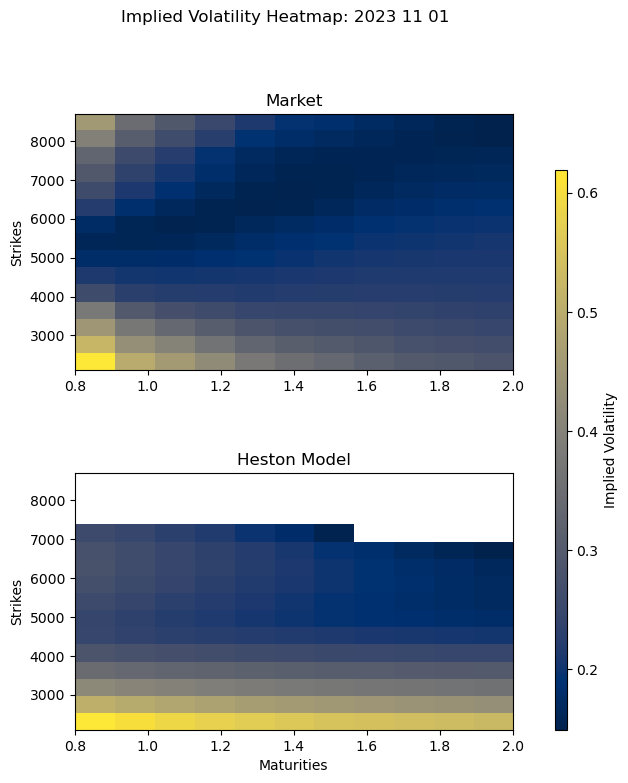

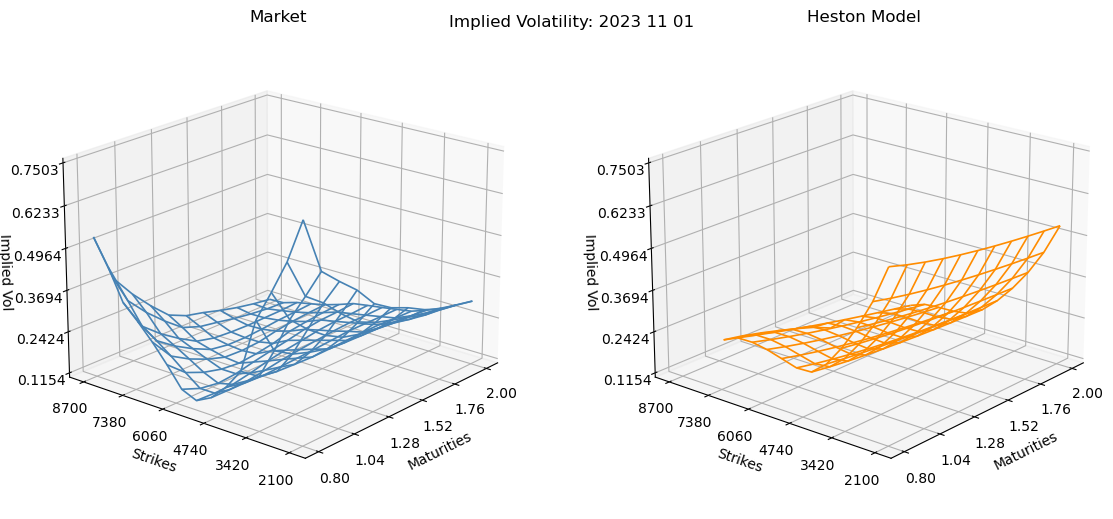

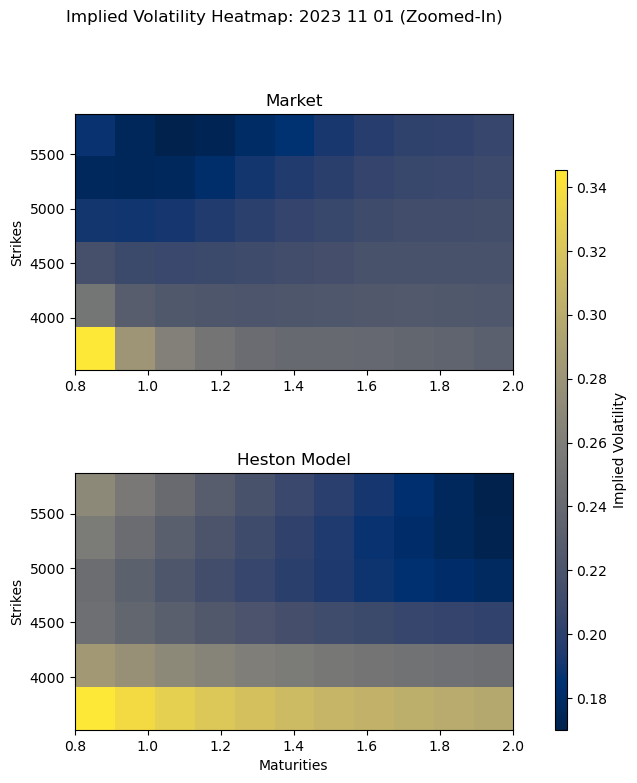

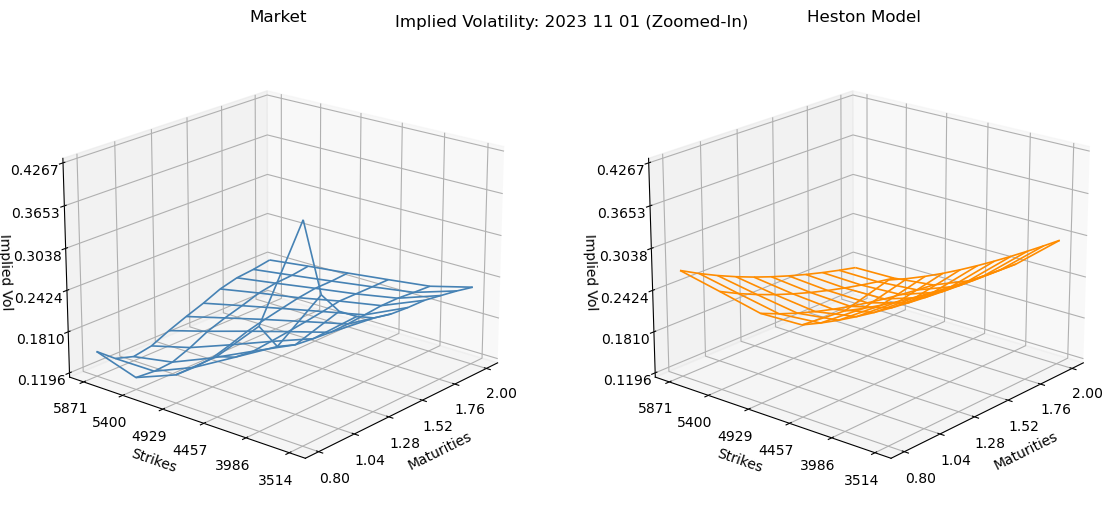

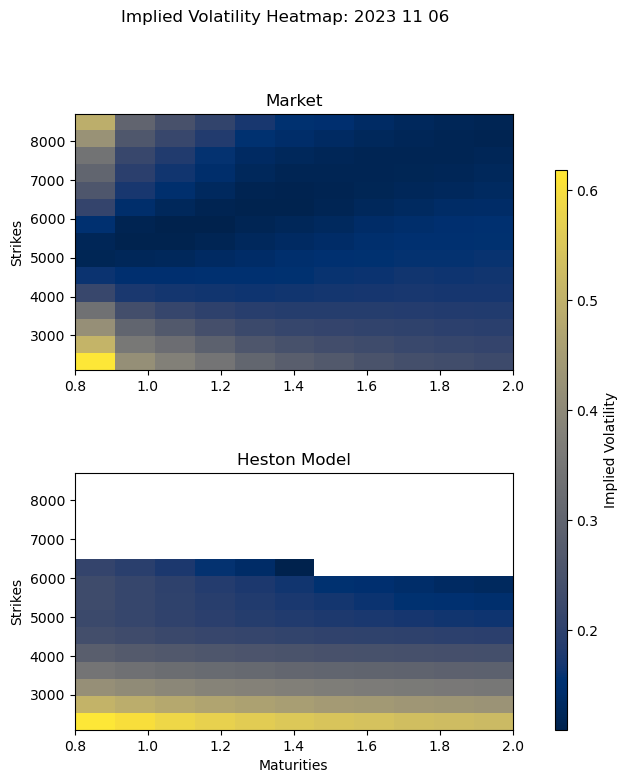

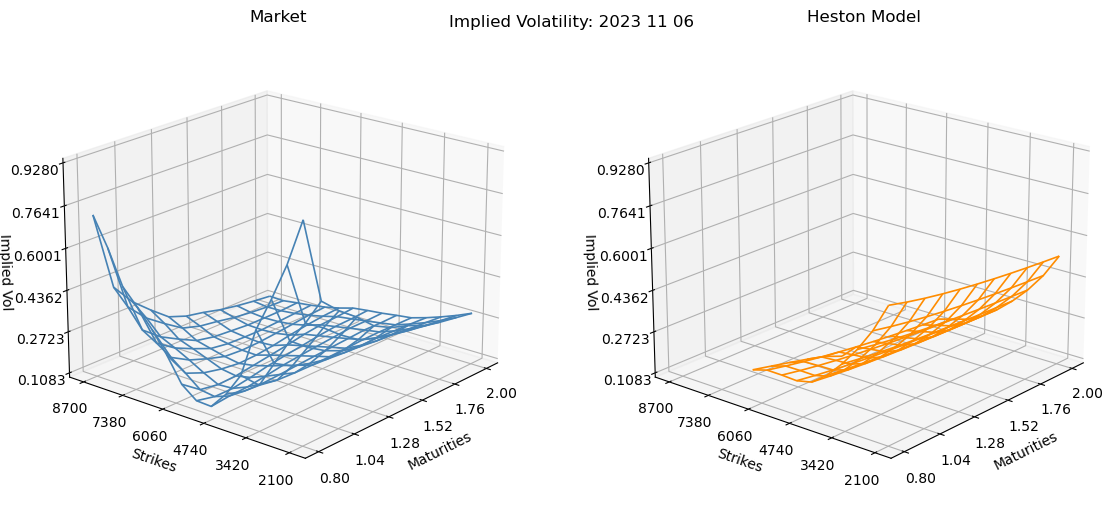

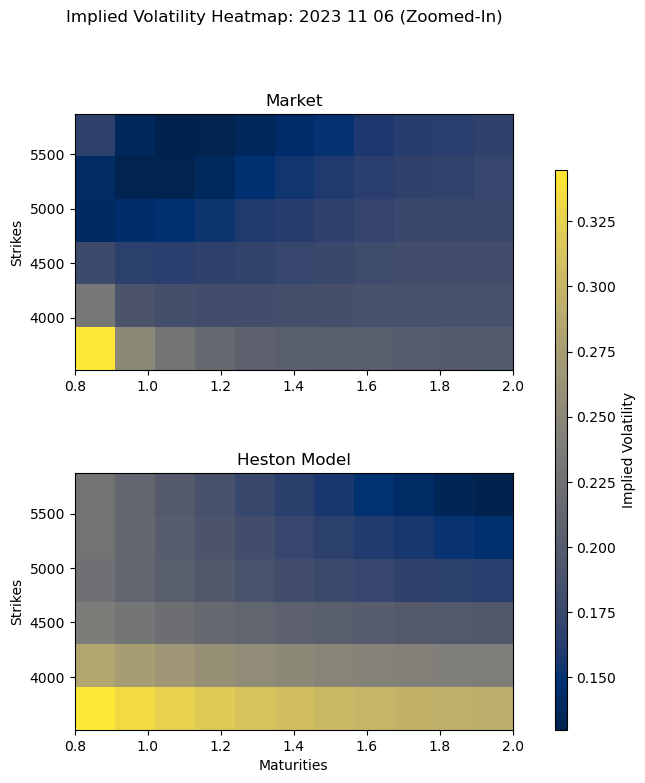

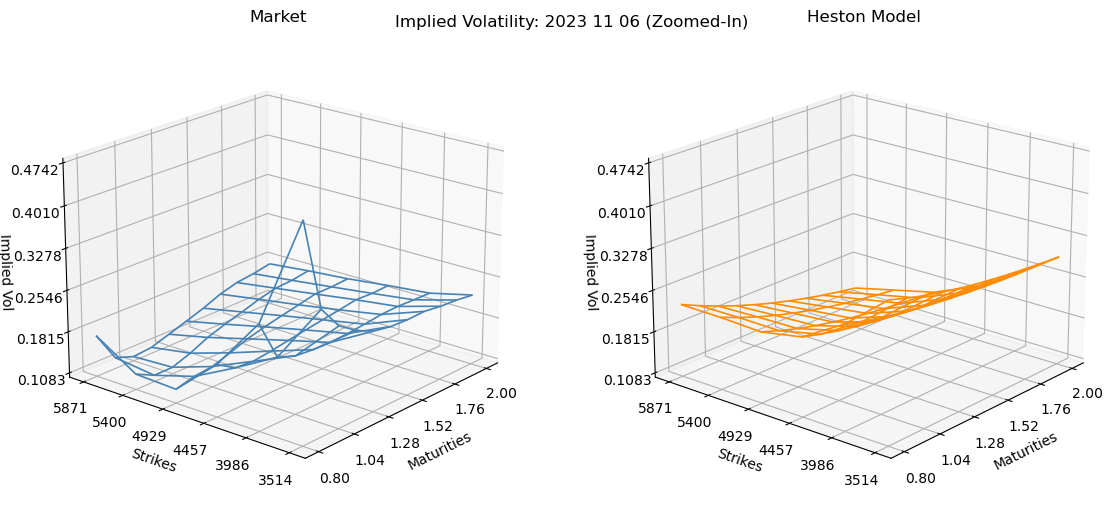

In [13]:
def compute_price_surface(
    s0: float,
    r: float,
    strike_grid: np.ndarray,
    maturity_grid: np.ndarray,
    params: dict,
) -> np.ndarray:
    """
    Compute model price surface given Heston parameters.

    Returns:
        price_grid: 2D array of shape (len(strike_grid), len(maturity_grid)).
    """
    kappa = params["kappa"]
    theta = params["theta"]
    sigma_v = params["sigma_v"]
    rho = params["rho"]
    v0 = params["v0"]

    price_grid = np.zeros((len(strike_grid), len(maturity_grid)))
    for i, K in enumerate(strike_grid):
        for j, T in enumerate(maturity_grid):
            price_grid[i, j] = heston_call_price(
                s0, K, T, r,
                kappa, theta, sigma_v, rho, v0
            )
    return price_grid


def plot_iv_heatmap(
    sigma_market: np.ndarray,
    sigma_model: np.ndarray,
    strike_grid: np.ndarray,
    maturity_grid: np.ndarray,
    date: str,
) -> None:
    """
    Plot side-by-side heatmaps of market vs. model implied vols,
    using custom colorbar positioning.
    """
    extent = (
        maturity_grid[0], maturity_grid[-1],
        strike_grid[0], strike_grid[-1],
    )
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(6, 8))
    im0 = ax0.imshow(
        sigma_market,
        origin='lower', aspect='auto', extent=extent,
        cmap='cividis'
    )
    ax0.set_title('Market')
    ax0.set_ylabel('Strikes')

    im1 = ax1.imshow(
        sigma_model,
        origin='lower', aspect='auto', extent=extent,
        cmap='cividis'
    )
    ax1.set_title('Heston Model')
    ax1.set_xlabel('Maturities')
    ax1.set_ylabel('Strikes')

    # Adjust spacing
    plt.subplots_adjust(left=0.15, right=0.88, top=0.92,
                        bottom=0.15, hspace=0.4)

    # Custom colorbar axis
    cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.70])
    cbar = fig.colorbar(im1, cax=cbar_ax, orientation='vertical')
    cbar.set_label('Implied Volatility')

    # Title above plots
    plt.suptitle(f'Implied Volatility Heatmap: {date}', y=1.05)
    fig.savefig(f'iv_heatmap_{date}.png', dpi=300,
                bbox_inches='tight')
    plt.show()



def plot_iv_wireframe(
    sigma_market: np.ndarray,
    sigma_model: np.ndarray,
    strike_grid: np.ndarray,
    maturity_grid: np.ndarray,
    date: str,
) -> None:
    """
    Plot side-by-side 3D wireframes of market vs. model implied vols.
    """
    # Create meshgrid with correct indexing
    K_mesh, T_mesh = np.meshgrid(strike_grid, maturity_grid, indexing='ij')

    fig = plt.figure(figsize=(12, 6))
    ax_mkt = fig.add_subplot(1, 2, 1, projection='3d')
    ax_mkt.plot_wireframe(
        T_mesh, K_mesh, sigma_market,
        color='steelblue', linewidth=1.2
    )
    ax_mkt.set(
        title='Market',
        xlabel='Maturities',
        ylabel='Strikes',
        zlabel='Implied Vol'
    )
    ax_mkt.view_init(elev=20, azim=-140)

    ax_mod = fig.add_subplot(1, 2, 2, projection='3d')
    ax_mod.plot_wireframe(
        T_mesh, K_mesh, sigma_model,
        color='darkorange', linewidth=1.2
    )
    ax_mod.set(
        title='Heston Model',
        xlabel='Maturities',
        ylabel='Strikes',
        zlabel='Implied Vol'
    )
    ax_mod.view_init(elev=20, azim=-140)

    # Set common ticks
    xticks = np.linspace(maturity_grid[0], maturity_grid[-1], 6)
    yticks = np.linspace(strike_grid[0], strike_grid[-1], 6)
    zticks = np.linspace(
        np.nanmin([sigma_market, sigma_model]),
        np.nanmax([sigma_market, sigma_model]),
        6
    )
    for ax in (ax_mkt, ax_mod):
        ax.set_xticks(xticks)
        ax.set_yticks(yticks)
        ax.set_zticks(zticks)

    fig.suptitle(f'Implied Volatility: {date}', y=0.85)
    fig.tight_layout(rect=[0, 0, 1, 0.9], w_pad=0.1)
    fig.savefig(f'iv_wireframe_{date}.png', dpi=300, bbox_inches='tight')
    plt.show()


# Main plotting workflow

# Map results by date
params_by_date = {res['date']: res for res in results}

for date in dates_to_check:
    sigma_market = raw_surfaces[date]['vols']
    params = params_by_date[date]

    # Compute model surfaces
    price_model = compute_price_surface(
        initial_spot_price,
        r_rate,
        strike_grid,
        maturity_grid,
        params,
    )
    sigma_model, _ = implied_vol_surface(
        price_model,
        strike_grid,
        maturity_grid,
        initial_spot_price,
        r_rate,
    )

    # Plot comparisons
    plot_iv_heatmap(
        sigma_market,
        sigma_model,
        strike_grid,
        maturity_grid,
        date,
    )
    plot_iv_wireframe(
        sigma_market,
        sigma_model,
        strike_grid,
        maturity_grid,
        date,
    )

    # Plot zoomed-in section
    zoom_strike_min = 3500
    zoom_strike_max = 6000
    strike_mask = (strike_grid >= zoom_strike_min) & (strike_grid <= zoom_strike_max)
    zoom_strikes = strike_grid[strike_mask]
    sigma_market_zoom = sigma_market[strike_mask, :]
    sigma_model_zoom = sigma_model[strike_mask, :]

    plot_iv_heatmap(
        sigma_market_zoom,
        sigma_model_zoom,
        zoom_strikes,
        maturity_grid,
        f"{date} (Zoomed-In)"
    )
    plot_iv_wireframe(
        sigma_market_zoom,
        sigma_model_zoom,
        zoom_strikes,
        maturity_grid,
        f"{date} (Zoomed-In)"
    )

